# Use BERT next sentence prediction on task1 

to measure the similarity of sentences


In [1]:
import torch 
from pytorch_transformers import BertForNextSentencePrediction
from pytorch_transformers import BertTokenizer

Some explaination about the `transformers`. 
- don't need to add additional words into the vocab: https://github.com/google-research/bert/issues/396 
- The tokenizer within the BERT can recognize the combined words. When working, it will seperate this kind of words into a word and a token beginning with `##`.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SEED=17

In [4]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [5]:
import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger("bert")

## Load the data 

Read from the csv file and only use the `ArticleTitle` and `ArticleDescription`.

In [6]:
import pandas as pd 
df=pd.read_excel("data/data_news_shorten.xlsx")[['ArticleTitle','ArticleDescription']]
df=df.fillna('')

In [7]:
df[10:20]

,ArticleTitle,ArticleDescription
10,Turkey's finance minister says inflation will ...,https://m.haberturk.com/bakan-albayrak-tan-o...
11,Rangers boss Steven Gerrard has high hopes for...,STEVEN GERRARD hopes new signings Jordan Jones...
12,Explained: How Arsenal can pip Tottenham to to...,Arsenal’s hopes of finishing in the top four a...
13,Canada-U.S. border transfers raise fear of del...,U.S. Customs and Border Protection says 731 no...
14,"ASVEL Villeurbanne wins French Cup, first sinc...",LDLC ASVEL Villeurbanne prevailed in the Frenc...
15,Urgent warning over MDMA after 15-year-old gir...,A 15-year-old girl has died after taking ecsta...
16,Richie Ramsay and Robert MacIntyre in the hunt...,
17,Rangers vs Celtic live stream: How to watch fi...,
18,Man's body found in wheelie bin behind Waitros...,"Death 'being treated as unexplained', says Sco..."
19,"Rich List: Jeremy Corbyn demands UK's 1,000 ri...","Corbyn says the Sunday Times Rich List shows ""..."


## Tokenize the data set

The input features contains:
- input id
- mask
- segment id


To construct the pair, long sentence would be truncated so that the length of two sentences would not go beyond the max_length.

In [8]:
class InputFeatures(object):
    '''
    A single set of features of data.
    '''

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

def truncate_seq_pair(tokens_a, tokens_b, max_length):
    '''
    Truncates a sequence pair in place to the maximum length.
    
    It is just a heuristic which always truncate the longer sentence on token at a time.
    Since we thought the each token in the shorter sentence contains more information.
    '''
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [9]:
def convert_sentence_pair(titles, descs, max_seq_length, tokenizer):
    '''
    Converter which can build the sentences pair (combining title & description)
    args:
        - titles: news title
        - descs: the description of the news
        - max_seq_length: the maximum length of the sentence
        - tokenizer: tokenizer used here. 
    returns:
        - features: list of defined class `InputFeatures`.
    '''
    features = []
    for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        
        # Account for [CLS], [SEP], [SEP] with "- 3"
        truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)
        
        # If the tokens_b exists, then add the `sep` token so that it can be fed into network
        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)
            
        # converts a string in a sequence of ids (integer), using the tokenizer and vocabulary.
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. 
        # Only real tokens are used。
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [11]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
# cache_dir parameter can be added into the function

08/02/2019 09:03:07 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/shuo/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [226]:
# tokenizer.tokenize("BAFTA TV Awards 2019: Stars prepare for glitzy ceremony as Killing Eve leads nominations")

In [12]:
# Build the sentences pairs based on the corpus
# I used the first 20 items for primary experiment
df_shorten=df[:20]
correct_pairs = convert_sentence_pair(df_shorten['ArticleTitle'].tolist(), 
                                      df_shorten['ArticleDescription'].tolist(), max_seq_length=200, tokenizer=tokenizer)


08/02/2019 09:03:09 - INFO - bert -   *** Example ***
08/02/2019 09:03:09 - INFO - bert -   tokens: [CLS] lowest ##oft sea wall fall cyclist rescued by friend [SEP] coast ##guard ##s praise the boy ' s friend for his actions in rescuing him after he fell 15 ##ft in lowest ##oft . [SEP]
08/02/2019 09:03:09 - INFO - bert -   input_ids: 101 7290 15794 2712 2813 2991 14199 10148 2011 2767 102 3023 18405 2015 8489 1996 2879 1005 1055 2767 2005 2010 4506 1999 23659 2032 2044 2002 3062 2321 6199 1999 7290 15794 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/02/2019 09:03:09 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

08/02/2019 09:03:09 - INFO - bert -   input_ids: 101 22284 2694 2982 10476 1024 3340 7374 2005 1043 24725 2100 5103 2004 4288 6574 5260 9930 102 3340 2024 8225 2005 4465 2305 1055 2694 22284 2015 2007 4288 6574 2877 9930 2012 1996 1043 24725 2100 5103 5889 2097 19311 2000 1996 2548 2782 2534 2005 1996 6261 2865 2329 2914 2547 2982 2007 16174 2036 2275 2000 26008 1999 17242 2015 18188 23550 1011 2958 1005 1055 2601 5021 4126 3689 5260 1996 9930 2007 2049 2048 2364 3340 1011 8183 10265 2272 2099 1998 12834 2821 1011 1999 1996 2770 2005 2877 1012 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/02/2019 09:03:09 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [13]:
len(correct_pairs)

20

## Build Model

Use the pre-trained model and do not do the fine-tuning, to see the performance.

In [14]:
import torch
from torch import nn
from pytorch_transformers import BertConfig
from torch.utils.data import TensorDataset, DataLoader

In [15]:
# Initialize the pre-trained model
config = BertConfig.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction(config)

# model.eval() 

08/02/2019 09:03:19 - INFO - pytorch_transformers.modeling_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/shuo/.cache/torch/pytorch_transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
08/02/2019 09:03:19 - INFO - pytorch_transformers.modeling_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

08/02/2019 09:03:19 - INFO - pytorch_transformers.tokenization_utils -   loa

In [16]:
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)

eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
eval_dataloader = DataLoader(eval_data)

In [17]:
model.eval()
# model.train()

res = []
for ids, seg, masks in eval_data:
    oout = nn.functional.softmax(model(ids.reshape(
        1, -1), seg.reshape(1, -1), masks.reshape(1, -1))[0], dim=1).detach().numpy()
    res.append(oout)

In [18]:
res

[array([[0.30782852, 0.6921715 ]], dtype=float32),
 array([[0.31590047, 0.68409956]], dtype=float32),
 array([[0.32670474, 0.67329526]], dtype=float32),
 array([[0.30522758, 0.6947724 ]], dtype=float32),
 array([[0.3187479, 0.6812521]], dtype=float32),
 array([[0.3223731 , 0.67762685]], dtype=float32),
 array([[0.3234897, 0.6765103]], dtype=float32),
 array([[0.31943876, 0.6805613 ]], dtype=float32),
 array([[0.30497646, 0.69502354]], dtype=float32),
 array([[0.30947736, 0.6905226 ]], dtype=float32),
 array([[0.32563278, 0.67436725]], dtype=float32),
 array([[0.3160002 , 0.68399984]], dtype=float32),
 array([[0.31082058, 0.6891794 ]], dtype=float32),
 array([[0.33268175, 0.6673182 ]], dtype=float32),
 array([[0.31610614, 0.68389386]], dtype=float32),
 array([[0.31328642, 0.6867136 ]], dtype=float32),
 array([[0.36489668, 0.6351033 ]], dtype=float32),
 array([[0.3618721, 0.638128 ]], dtype=float32),
 array([[0.30842495, 0.69157505]], dtype=float32),
 array([[0.3103882, 0.6896118]], dtyp

The output of the model:
- For one sentences pair, the result is a [1,2] tensor of logits. The `output[0,0]` is the score of Next sentence being `True` and the `output[0,1]` is the score that Next sentence being `False`. 
- In the above code, `softmax` function is applied to the output. So the final output can be seen as the probability of whether Next sentence being `true` or `false`.

From the results, it shows that the pre-trained model without further training can't behave well on capturing the relation between sentence pair. The input sentence pairs are all pairs of **Title & Description**. The results of the first 20 news data set shows that the next sentence being False has higher probability.

To make the model behave better on my corpus, the training is important.

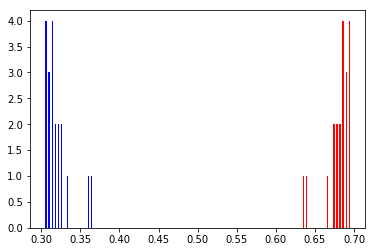

In [23]:
import matplotlib.pyplot as plt 

res_c=np.concatenate(res)
# print(res_c)
_ = plt.hist(res_c, bins=100,color=['b','r'])
plt.show()
# The figure show that the performance is really not good 

The locations of blue columns should show the probablity of Next sentence being True, while red ones show the Next sentence being False. The current model doesn't behave well.

**Test single pair sentences to get familiar with it**

In [27]:
# custom test for single 
# title=["Meanwhile: For a Knife, Dagger, Sword, Machete or Zombie-Killer, Just Ask These Ladies"]
title=['Djokovic prevails over Tsitsipas to claim third Madrid title']

# descri=[" Whitehead’s Cutlery in Butte, Mont., is 128 years old and will gladly sharpen scissors sold generations ago."]
descri=['World No.1 Novak Djokovic claimed a third Madrid Open crown by defeating Stefanos Tsitsipas 6-3, 6-4.']

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
sentences_pairs=convert_sentence_pair(title,descri,40,tokenizer)



08/02/2019 09:15:43 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/shuo/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
08/02/2019 09:15:43 - INFO - bert -   *** Example ***
08/02/2019 09:15:43 - INFO - bert -   tokens: [CLS] dj ##oko ##vic pre ##va ##ils over ts ##its ##ip ##as to claim third madrid title [SEP] world no . 1 novak dj ##oko ##vic claimed a third madrid open crown by defeating stefano ##s ts ##its ##ip [SEP]
08/02/2019 09:15:43 - INFO - bert -   input_ids: 101 6520 16366 7903 3653 3567 12146 2058 24529 12762 11514 3022 2000 4366 2353 6921 2516 102 2088 2053 1012 1015 19580 6520 16366 7903 3555 1037 2353 6921 2330 4410 2011 6324 19618 2015 24529 12762 11514 102
08/02/2019 09:15:43 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [28]:
single_input_id=torch.tensor(sentences_pairs[0].input_ids).reshape(1,-1)
single_input_mask=torch.tensor(sentences_pairs[0].input_mask).reshape(1,-1)
single_segment_id=torch.tensor(sentences_pairs[0].segment_ids).reshape(1,-1)

# single_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
# all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
# all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)

In [29]:
model = BertForNextSentencePrediction(config)
model.eval()
model(single_input_id,single_segment_id,single_input_mask)

(tensor([[-0.3165,  0.0569]], grad_fn=<AddmmBackward>),)

---

Due to the limited time, I didn't explore BERT more for this task. Using `BertForNextSentencePrediction` could be a idea for this task, but the model needs to be trained so that it can know better on the our corpus.

More could do:
- Fine tune. Huggig face also supply the script to guide how to fine tune. Using the https://github.com/huggingface/pytorch-transformers/blob/master/examples/lm_finetuning/simple_lm_finetuning.py 
- I did the NER using `spacy` this time. BERT is also capable to do NER, further work could be exploring the variation of BERT on multiple task.